In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import re
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [3]:
train_data = pd.read_csv("./data/train_superset.csv")
test_data = pd.read_csv("./data/test_superset.csv")

In [4]:

np.random.seed(0)
df_train, df_test = train_test_split(train_data, train_size = 0.8, test_size = 0.2, random_state = 100)

In [5]:
df_train.head()

,flat_type,floor_area_sqm,monthly_rent,property_age,nearest_mrt_exist,nearest_mrt_planned,nearest_school,nearest_mall,mrt_within_0.5_km,mrt_within_1_km,school_within_1_km,school_within_2_km,malls_within_1_km,malls_within_2_km,mean_coe,max_coe,min_coe,last_month_mean,last_month_max,last_month_min,year,month,region_East Region,region_North Region,region_North-East Region,region_West Region,flat_model_3gen,flat_model_adjoined_flat,flat_model_apartment,flat_model_dbss,flat_model_improved,flat_model_maisonette,flat_model_model_a,flat_model_model_a2,flat_model_model_a_maisonette,flat_model_new_generation,flat_model_premium_apartment,flat_model_premium_apartment_loft,flat_model_premium_maisonette,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type_s1_s2,subzone_encoded,planning_area_encoded
41147,5,121.0,1500,51,0.708492,0.988849,0.159010,0.449148,0,1,5,10,2,6,52199.625,63002,41701,14.152774,16.571078,13.891529,2021,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2312.551440,2642.766006
18711,4,91.0,2600,51,0.406746,0.422217,0.479670,0.331025,2,2,2,5,4,4,50396.750,62100,36134,13.250911,16.250480,12.501900,2021,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2821.149144,2651.027703
27074,3,67.0,1700,53,0.998074,0.994500,0.629829,0.931079,0,1,5,10,1,3,92845.000,107889,77109,9.359630,10.440439,8.907474,2023,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2363.131936,2440.906571
12670,5,120.0,2150,51,0.699345,1.500724,0.368022,0.428953,0,1,6,14,2,8,45187.375,51900,35900,12.585338,14.739780,11.920820,2021,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2541.063596,2624.597383
47874,5,115.0,3350,52,1.896037,2.127675,0.298985,0.240401,0,0,2,10,3,6,79016.000,99010,48889,11.753082,14.020345,10.865200,2022,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2605.029586,2624.597383


In [6]:
y_train_all = train_data.pop('monthly_rent')
X_train_all = train_data

In [7]:
y_train = df_train.pop('monthly_rent')
X_train = df_train

In [8]:
y_test = df_test.pop('monthly_rent')
X_test = df_test

In [9]:
gbm = lgb.LGBMRegressor(n_estimators = 100)
gbm.fit(X_train, y_train,eval_metric='rmse')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 47581, number of used features: 40
[LightGBM] [Info] Start training from score 2593.194763


LGBMRegressor()

In [10]:

y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
print('The rmse of train prediction is: ', round(mean_squared_error(y_pred, y_train) ** 0.5, 5))
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The rmse of test prediction is:', round(mean_squared_error(y_pred, y_test) ** 0.5, 5))
fea_imp_ = pd.DataFrame({'cols':X_train.columns, 'fea_imp':gbm.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)

The rmse of train prediction is:  466.57017
The rmse of test prediction is: 485.75093


,cols,fea_imp
1,floor_area_sqm,353
4,nearest_mrt_planned,252
3,nearest_mrt_exist,248
42,subzone_encoded,238
6,nearest_mall,208
5,nearest_school,196
13,mean_coe,180
43,planning_area_encoded,175
10,school_within_2_km,125
0,flat_type,124


In [11]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1, 42))}]

# create model
gbm = lgb.LGBMRegressor(n_estimators = 100)
gbm.fit(X_train, y_train)
rfe = RFE(gbm)

# call GridSearchCV() with r2score
model_cv_r2 = GridSearchCV(estimator = rfe,
                        param_grid = hyper_params,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)

# call GridSearchCV() with neg_mean_squared_error
model_cv_mse = GridSearchCV(estimator = rfe,
                        param_grid = hyper_params,
                        scoring= 'neg_mean_squared_error',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 47581, number of used features: 40
[LightGBM] [Info] Start training from score 2593.194763


In [12]:
model_cv_r2.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1681
[LightGBM] [Info] Number of data points in the train set: 38065, number of used features: 34
[LightGBM] [Info] Start training from score 2593.667411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 38065, number of used features: 33
[LightGBM] [Info] Start training from score 2593.667411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1677
[LightGBM] [Info] Number of data 

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LGBMRegressor()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [13]:
cv_results_r2 = pd.DataFrame(model_cv_r2.cv_results_)
cv_results_r2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,27.125184,0.420537,0.094259,0.032457,1,{'n_features_to_select': 1},0.010525,0.018048,0.017723,0.011739,0.015927,0.014792,0.003099,41,0.026972,0.026607,0.026091,0.025063,0.024236,0.025794,0.001010
1,27.054270,0.050513,0.046693,0.001704,2,{'n_features_to_select': 2},0.074428,0.075197,0.068131,0.069627,0.069468,0.071370,0.002869,40,0.108871,0.108906,0.109381,0.113230,0.112218,0.110521,0.001836
2,28.641103,3.504618,0.059006,0.001454,3,{'n_features_to_select': 3},0.135050,0.192545,0.187962,0.177665,0.184757,0.175596,0.020844,39,0.173272,0.229608,0.227728,0.233351,0.229661,0.218724,0.022799
3,26.717124,0.722396,0.065044,0.003100,4,{'n_features_to_select': 4},0.219278,0.226870,0.220423,0.211196,0.221290,0.219811,0.005038,38,0.265911,0.263792,0.266184,0.269049,0.265316,0.266050,0.001713
4,26.858038,1.107101,0.067269,0.004297,5,{'n_features_to_select': 5},0.525459,0.512945,0.521632,0.508167,0.520705,0.517782,0.006295,37,0.559412,0.561430,0.560781,0.562757,0.561495,0.561175,0.001089
5,26.132366,0.362848,0.065380,0.000801,6,{'n_features_to_select': 6},0.524606,0.514258,0.521777,0.508474,0.520783,0.517980,0.005838,36,0.561399,0.565903,0.563872,0.565240,0.564925,0.564268,0.001577
6,25.692362,0.445576,0.068574,0.005542,7,{'n_features_to_select': 7},0.525770,0.516392,0.523383,0.508004,0.519978,0.518705,0.006217,35,0.564506,0.568050,0.565564,0.568589,0.566103,0.566562,0.001533
7,25.188398,0.476239,0.074812,0.008243,8,{'n_features_to_select': 8},0.530721,0.518932,0.524478,0.511674,0.525094,0.522180,0.006444,34,0.568950,0.572515,0.569902,0.573272,0.569678,0.570863,0.001704
8,24.782484,0.525319,0.067840,0.004420,9,{'n_features_to_select': 9},0.534164,0.520969,0.529080,0.509704,0.526699,0.524123,0.008365,33,0.569957,0.574090,0.572775,0.575363,0.573031,0.573043,0.001793
9,25.230700,1.371693,0.070291,0.004319,10,{'n_features_to_select': 10},0.534760,0.520944,0.527018,0.512187,0.525932,0.524168,0.007448,32,0.572732,0.575236,0.574487,0.576982,0.575390,0.574965,0.001381


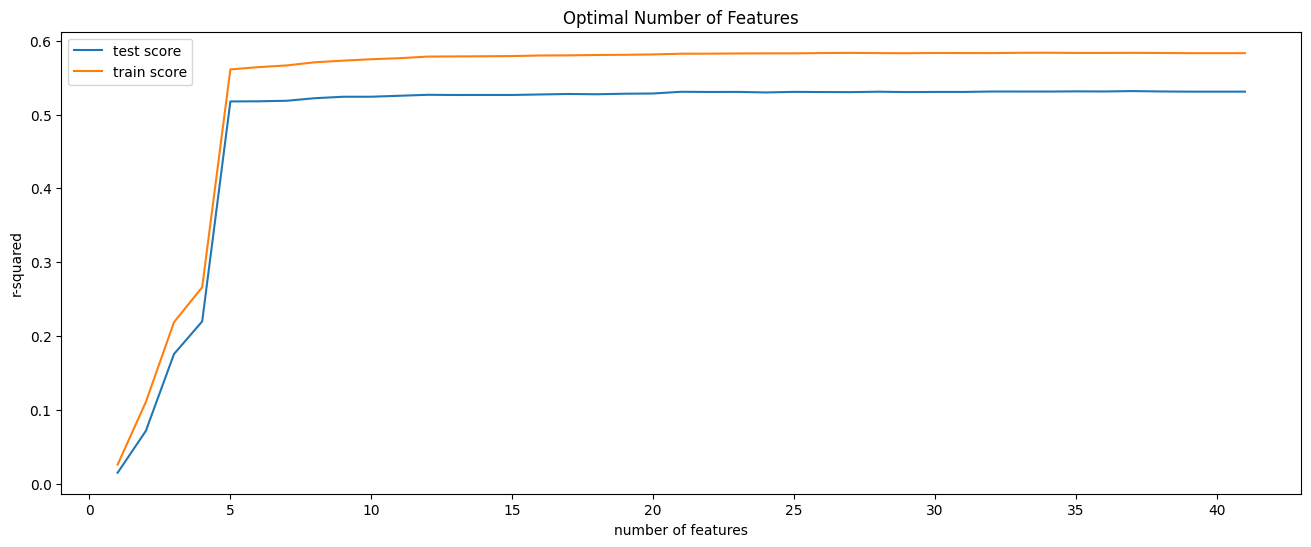

In [14]:

# plotting cv results
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))

plt.plot(cv_results_r2["param_n_features_to_select"], cv_results_r2["mean_test_score"])
plt.plot(cv_results_r2["param_n_features_to_select"], cv_results_r2["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [15]:
gbm = lgb.LGBMRegressor()
rfe = RFE(estimator=gbm, n_features_to_select=20)
rfe = rfe.fit(X_train, y_train)
selected_columns_20 = X_train.columns[rfe.support_]
X_train_20 = X_train[selected_columns_20]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 47581, number of used features: 40
[LightGBM] [Info] Start training from score 2593.194763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 47581, number of used features: 40
[LightGBM] [Info] Start training from score 2593.194763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

In [16]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = { 'max_depth': [5, 8, 10],
                'learning_rate': [0.01, 0.1, 0.2],
                'n_estimators': [50, 100, 200],
                'min_child_samples': [10,20, 30],
                'reg_lambda': [0.1, 0.5],
                'random_state': [42]
}

gbm = lgb.LGBMRegressor()

model_cv = GridSearchCV(estimator = gbm,
                        param_grid = hyper_params,
                        scoring= 'neg_mean_squared_error',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)


In [17]:
model_cv.fit(X_train_20, y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [5, 8, 10],
                         'min_child_samples': [10, 20, 30],
                         'n_estimators': [50, 100, 200], 'random_state': [42],
                         'reg_lambda': [0.1, 0.5]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [18]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_samples,param_n_estimators,param_random_state,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.391474,0.009880,0.020311,0.000668,0.01,5,10,50,42,0.1,"{'learning_rate': 0.01, 'max_depth': 5, 'min_c...",-354736.499997,-354052.500912,-353330.281611,-372557.317163,-351312.478146,-357197.815566,7764.797272,157,-356793.544230,-356238.228637,-356615.927336,-351716.423591,-357082.643084,-355689.353376,2005.216601
1,0.388224,0.006698,0.020254,0.000742,0.01,5,10,50,42,0.5,"{'learning_rate': 0.01, 'max_depth': 5, 'min_c...",-354819.866642,-354106.805388,-353414.712223,-372622.553565,-351349.740890,-357262.735742,7766.882290,160,-356858.865667,-356301.146778,-356662.824967,-351792.509034,-357124.080836,-355747.885456,1995.815913
2,0.687050,0.119552,0.041500,0.004298,0.01,5,10,100,42,0.1,"{'learning_rate': 0.01, 'max_depth': 5, 'min_c...",-292764.188375,-294721.630201,-292521.016769,-312250.673809,-290883.838695,-296628.269570,7905.617282,140,-295120.172192,-293907.688921,-294451.838287,-289910.647620,-294978.296303,-293673.728665,1929.511157
3,0.840926,0.176370,0.046689,0.009415,0.01,5,10,100,42,0.5,"{'learning_rate': 0.01, 'max_depth': 5, 'min_c...",-292769.578972,-294756.443756,-292539.500577,-312331.184336,-290922.422381,-296663.826004,7927.712909,142,-295188.417995,-293961.977980,-294505.650198,-289980.679793,-295014.979314,-293730.341056,1923.070635
4,1.116650,0.014990,0.085983,0.001719,0.01,5,10,200,42,0.1,"{'learning_rate': 0.01, 'max_depth': 5, 'min_c...",-254589.825782,-259249.077238,-255926.810780,-275112.113176,-255042.428137,-259984.051022,7737.918997,122,-255898.187355,-254696.620999,-255009.463187,-250868.050713,-255344.026970,-254363.269845,1792.378415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.371039,0.004538,0.034997,0.000525,0.2,10,30,50,42,0.5,"{'learning_rate': 0.2, 'max_depth': 10, 'min_c...",-237182.236368,-241126.146382,-239616.478501,-256756.264906,-239969.536174,-242930.132466,7031.358995,53,-218342.179804,-217529.375947,-217928.689975,-213532.256604,-217656.307903,-216997.762047,1754.999138
158,0.653998,0.141585,0.063829,0.007354,0.2,10,30,100,42,0.1,"{'learning_rate': 0.2, 'max_depth': 10, 'min_c...",-238819.696888,-241662.168530,-239530.470834,-257302.999527,-241308.355443,-243724.738244,6871.878767,70,-201432.158838,-199942.779507,-200223.192177,-196796.296124,-200679.741888,-199814.833707,1591.131839
159,0.641605,0.152512,0.064417,0.007897,0.2,10,30,100,42,0.5,"{'learning_rate': 0.2, 'max_depth': 10, 'min_c...",-239119.446693,-240879.130571,-239799.251928,-258208.244824,-241444.702618,-243890.155327,7204.850413,73,-201352.653361,-200947.663129,-200504.476318,-197094.606683,-200072.271056,-199994.334109,1511.860165
160,0.833461,0.040417,0.104921,0.002160,0.2,10,30,200,42,0.1,"{'learning_rate': 0.2, 'max_depth': 10, 'min_c...",-241924.162996,-244435.527670,-243428.066562,-259554.544349,-244110.786355,-246690.617587,6489.759626,99,-177664.630820,-175397.065496,-174728.837825,-172382.807539,-176250.947853,-175284.857907,1751.587515


In [19]:
print("best parameters : " , model_cv.best_estimator_)
print("best score : " , model_cv.best_score_)

best parameters :  LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,
              random_state=42, reg_lambda=0.1)
best score :  -240859.91138099087


In [20]:
from sklearn.model_selection import cross_val_score

# create model
gbm = lgb.LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,random_state=42, reg_lambda=0.1)
scores = cross_val_score(gbm, X_train_20, y_train, cv=5, scoring='neg_root_mean_squared_error')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 38064, number of used features: 20
[LightGBM] [Info] Start training from score 2593.148382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

In [21]:
scores

array([-492.53715697, -488.211828  , -489.02752487, -491.93394273,
       -493.10084722])

In [22]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-490.96 accuracy with a standard deviation of 1.96


In [23]:
gbm = lgb.LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,random_state=42, reg_lambda=0.1)
scores = cross_val_score(gbm, X_train_20, y_train, cv=5, scoring='r2')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 38064, number of used features: 20
[LightGBM] [Info] Start training from score 2593.148382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

In [24]:
scores

array([0.53812202, 0.54418968, 0.52902319, 0.51983215, 0.5193256 ])

In [25]:
gbm = lgb.LGBMRegressor(max_depth=5, min_child_samples=30, n_estimators=200,random_state=42, reg_lambda=0.1)
gbm.fit(X_train_20, y_train)
y_pred = gbm.predict(X_train_20)
y_pred= (y_pred / 10).round() * 10
print('The rmse of train prediction is: ', round(mean_squared_error(y_pred, y_train) ** 0.5, 5))
print('The r2 of train prediction is: ', r2_score(y_train,y_pred))
y_pred = gbm.predict(X_test[X_train_20.columns.tolist()], num_iteration=gbm.best_iteration_)
y_pred= (y_pred / 10).round() * 10
print('The rmse of test prediction is:', round(mean_squared_error(y_pred, y_test) ** 0.5, 5))
print('The r2 of test prediction is:', r2_score(y_test, y_pred))
fea_imp_ = pd.DataFrame({'cols':X_train_20.columns, 'fea_imp':gbm.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1614
[LightGBM] [Info] Number of data points in the train set: 47581, number of used features: 20
[LightGBM] [Info] Start training from score 2593.194763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

,cols,fea_imp
1,floor_area_sqm,554
3,nearest_mrt_planned,439
4,nearest_school,423
2,nearest_mrt_exist,418
18,subzone_encoded,383
5,nearest_mall,350
19,planning_area_encoded,276
12,mean_coe,239
9,school_within_2_km,208
14,min_coe,181


In [26]:
#Final Model Predictions
y_pred = gbm.predict(test_data[X_train_20.columns.tolist()], num_iteration=gbm.best_iteration_)
y_pred= (y_pred / 10).round() * 10
y_test_20 = test_data[["Id"]]
y_test_20["Predicted"] = y_pred
y_test_20= y_test_20.sort_values(by = "Id")
y_test_20.to_csv("./data/lgbm_20.csv", index = False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
